# HW1.1 Cifar10 Classification

>**作業說明**

請**第一步驟**: 左上角 檔案->在雲端硬碟建立副本。

請**第二步驟**: 右上角 共用->取得連結->任何知道這個連結的人都能編輯

請**第三步驟**: 左上角 執行階段->更變執行類型->GPU。 可以加快模型速度

請 **隨意修改** 這個colab的程式來完成訓練CNN模型。**只要跑得出來Testing Accuracy、Loss; 1~7個作業項目即可**，不必一定要照著todo提示走。
繳交時記得改檔案標題的學號。

本次作業著重在前處理，現實中很多筆資料的label不見得會直接給你，很多都會在奇怪的位置，例如本次作業，label隱藏在圖片名稱之中。你需要做很多前處理來提取標籤。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看test data
2. 模型請手刻、手疊，**不要用Transfer Learning**來引入ResNet、Inception...等知名模型來增加準確率。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名姓名**，左上角 檔案->下載 成ipynb檔。
2. 交一個pdf檔，裡面需要附上**你的作業colab連結(設為可編輯)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 上述兩個檔案繳交至ee-class。

> **繳交期限**

1. 電子商務智慧技術(IMA0200): 期限至2012/4/2(五) 23:59分

有問題再直接Line助教，我有空就會秒回

## 1. 讀入封包

深度學習一般目前市場上常見的有tensorflow、keras、pytorch。本次Demo使用keras，keras是一個簡單好用的模型訓練工具。能夠幫助初學者省去很多在訓練上的細節，使機器學習更加快速、好上手。

In [105]:
# -- 建立 CNN 神經網路架構 -- #
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt

## 2. 取得資料集

* 由keras內部method可以線上取得Cifar10的資料集。並且已經自動分離出了訓練用與測試用的資料集。
* x_train是一個包含50000張圖片。
* x_train要預測的是y_train的50000個對應標籤，分別是當前對應圖片的0~9數字。因此共十個class。

In [106]:
# -- 載入 cifar10 資料集 -- #
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# -- 查看資料的 shape -- #
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

print("="*40)
# -- 查看標籤的 shape -- #
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 32, 32, 3)
y_test shape:  (10000, 1)


https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib.pyplot.imshow

cmap: str or Colormap, default: rcParams["image.cmap"] (default: 'viridis')
The Colormap instance or registered colormap name used to map scalar data to colors. **This parameter is ignored for RGB(A) data.**
* 我們可以實際將這些圖片印出來看看
* Cifar10每個標籤的意義如下

![](https://i.imgur.com/Vz5IsTL.png)

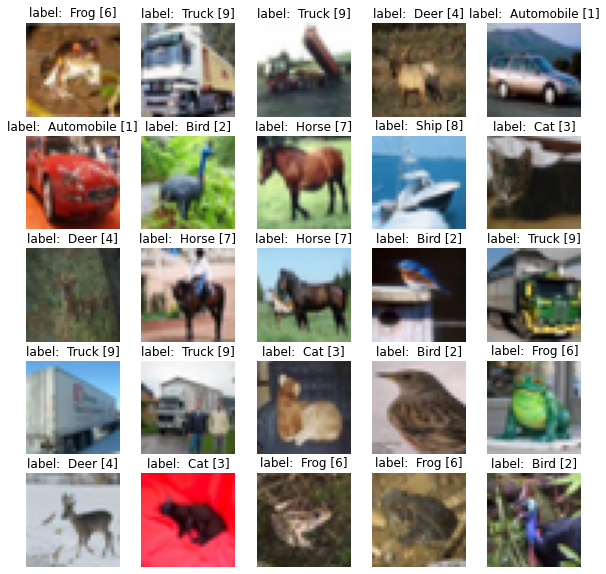

In [111]:
# 印出來看看
plt.figure(figsize=(10, 10))

labels = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]
for i in range(25):
    img = x_train[i]  # 圖片
    plt.subplot(5,5,i+1)
    plt.imshow(img)   # cmap is ignored for RGB(A) data
    plt.title("label: " + " {}".format(labels[int(y_train[i])]) + " {}".format(y_train[i])) # 索引值
    plt.axis("off")

## 3. 資料前處理
從第二步的結果，看看出圖片的維度是 (32,32,3)

* 可以知道一張圖片的維度是(28,28)，但是實際輸入模型的維度是(28,28,1)。灰階圖片少了channel，所以我們要拓展維度 (作為channel)

* 然後我們要把圖片pixel 自 [0,255] --> [0,1] ，讓深度學習在矩陣相乘時不會因為數值相乘太大而很難訓練。

In [113]:
##########
# todo #
##########
# 針對圖片 進行 min-max normalization...
x_train_norm = x_train.astype('float32') / 255 # 每個像素值除以 255
x_test_norm = x_test.astype('float32') / 255  # 每個像素值除以 255

# -- min-max normalization 後 -- #
print(x_train_norm[0][0][0])
print(x_test_norm[0][0][0])

[0.23137255 0.24313726 0.24705882]
[0.61960787 0.4392157  0.19215687]


- 然後要把label轉為one-hot。因為我們預期模型訓練是
    - 輸入: (28,28,1) 的圖片
    - 輸出: (10,) 的機率
    
    
- 打個比方:
    - ![](https://i.imgur.com/aCYEeRB.png)
    - 所以我們需要將label轉成one-hot 格式

In [124]:
# 針對索引值 進行 One-hot 編碼轉換...
num_classes = 10
y_train_label = keras.utils.to_categorical(y_train, num_classes) # 將訓練標籤進行 One-hot 編碼
y_test_label = keras.utils.to_categorical(y_test, num_classes)  # 將測試標籤進行 One-hot 編碼

# 轉換後
for i in range(10):
    print(y_train[i]," ---> ",y_train_label[i])

[6]  --->  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[9]  --->  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[9]  --->  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[4]  --->  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1]  --->  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1]  --->  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[2]  --->  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[7]  --->  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[8]  --->  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[3]  --->  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## 4. 建立模型

我們本次建立的模型CNN，由Convolution層與Fully Connection層組成

#### **對Keras來說**

1. 一張圖片通過**Conv**後維度計算: [keras Conv](https://keras.io/api/layers/convolution_layers/convolution2d/)
* 默認stride:(1,1)
* 默認padding = None
* Input: $(N,H_{in},W_{in},C_{in})$
* Output: $(N,H_{out},W_{out},C_{out})$
* $H_{out} =\frac{[H_{in}+2*padding-kernal]}{stride} +1$
* $W_{out} =\frac{[W_{in}+2*padding-kernal]}{stride} +1$

> E.g.
>
> input: **(32,28,28,3)**
>
> kernel: 3,padding=0,stride=1,filters=32
> 
> $(28-2*0-3)/1 + 1 = 26$
>
> output: **(32,26,26,32)**

2. 一張圖片通過**MaxPooling**後維度計算:[keras MaxPooling](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
* 默認pooing_size:(2,2)
* 默認padding : None
* 默認stride : pooling_size
* Input: $(N,H_{in},W_{in},C_{in})$
* Output: $(N,H_{out},W_{out},C_{out})$
* $H_{out} =\frac{[H_{in}+2*padding-poolingKernel]}{stride} +1$
* $W_{out} =\frac{[W_{in}+2*padding-poolingKernel]}{stride} +1$

> E.g.
>
> input: **(32,26,26,32)**
>
> kernel:2,padding=0,stride=2
> 
> $(26-2*0-2)/2 + 1 = 13$
>
> output: **(32,13,13,32)**

![](https://i.imgur.com/x6rG5gb.png)

In [171]:
##########
# todo #
##########
# 卷積層使用的 輸入
input_shape = (32, 32, 3)

##########
# todo #
##########
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), # 卷積層
        #layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'), # 卷積層
        #layers.Dropout(0.25),                             # Dropout
        layers.MaxPooling2D(pool_size=(2, 2)),                    # 池化層       
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), # 卷積層
        #layers.Dropout(0.25),                             # Dropout        
        layers.MaxPooling2D(pool_size=(2, 2)),                    # 池化層
        layers.Flatten(),                               # 展平層
        layers.Dense(512, activation="relu"),                    # 密集層
        layers.Dropout(0.5),                             # Dropout
        layers.Dense(num_classes, activation="softmax"),               # 密集層 (輸出分類)
    ]
)

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               1180160   
_________________________________________________________________
dropout_40 (Dropout)         (None, 512)             

## 5. 制定訓練計畫

- 制定訓練計畫包含該如何進行訓練
    - batch_size : 因為神經網路其實只是矩陣相乘，我們可以擴大丟入模型的圖片數量，這個就是一次要丟入幾張圖片。
    - epochs : 總共要循環幾次所有訓練資料集來訓練模型 
    - loss : 預測值與真實label之間的差距計算方式
    - optimizer : 運練更新模型的方法
    - metrics : keras 訓練過程中恆量模型的方法
    - validation dataset : 在一開始將training data部分資料剝離，所以模型完全不會偷看到validation data。這部分的資料用來在訓練過程中檢視模型的好壞。
    
- 訓練步驟
    - keras不需要你寫訓練步驟，你只要在model.fit把input資料與true label丟入即可

In [180]:
##########
# todo #
##########
# 每個批次用 128 筆資料進行訓練
batch_size = 128
# 20 個訓練週期 (次數) 
epochs = 10

validation_split = 0.1

##########
# todo #
##########
# model.compile 決定learning strategy、Loss caculator

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit( x=x_train_norm,          # 訓練資料
            y=y_train_label,          # 訓練標籤
            batch_size=batch_size,      # 每個批次用 128 筆資料進行訓練
            epochs=epochs,          # 20 個訓練週期 (次數) 
            validation_split=validation_split # # 拿出訓練資料的 20% 做為驗證資料
          )

Epoch 1/10
352/352 [==============================] - 3s 7ms/step - loss: 0.7634 - accuracy: 0.7470 - val_loss: 0.8454 - val_accuracy: 0.7134
Epoch 2/10
352/352 [==============================] - 2s 6ms/step - loss: 0.6191 - accuracy: 0.7862 - val_loss: 0.8513 - val_accuracy: 0.7170
Epoch 3/10
352/352 [==============================] - 2s 6ms/step - loss: 0.5814 - accuracy: 0.7993 - val_loss: 0.8519 - val_accuracy: 0.7166
Epoch 4/10
352/352 [==============================] - 2s 6ms/step - loss: 0.5491 - accuracy: 0.8110 - val_loss: 0.8556 - val_accuracy: 0.7242
Epoch 5/10
352/352 [==============================] - 2s 6ms/step - loss: 0.5030 - accuracy: 0.8252 - val_loss: 0.8780 - val_accuracy: 0.7212
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 0.4653 - accuracy: 0.8384 - val_loss: 0.8553 - val_accuracy: 0.7260
Epoch 7/10
352/352 [==============================] - 2s 6ms/step - loss: 0.4429 - accuracy: 0.8437 - val_loss: 0.9228 - val_accuracy: 0.7102
Epoch 

## 6. 評估模型

- 查看訓練過程中的成果
    - val accuracy、 loss 與train data相比
    - 要是train acc比val acc大很多，train loss比val loss 小很多，則稱為overfitting。模型不夠泛化，太專注於看過的東西了。

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


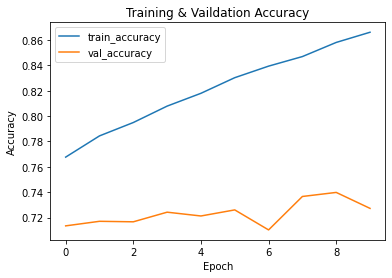

In [181]:
print(history.history.keys())

# 繪製準確率與驗證準確度的歷史線圖
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Vaildation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["train_accuracy", "val_accuracy"], loc="best")
plt.show()



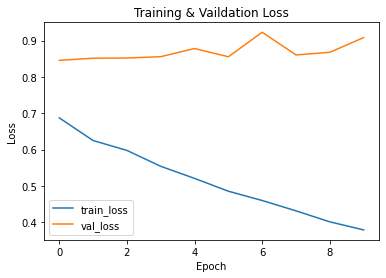

In [182]:
#  繪製損失及驗證損失的歷史線圖
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Vaildation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["train_loss", "val_loss"], loc="best")
plt.show()

- **測試模型**
經過train、val data來調整完成模型後，用model完全沒看過的資料 test data來測試模型準確度

In [183]:
# -- 使用測試資料評估神經網路 -- #
score = model.evaluate(x=x_test_norm, 
             y=y_test_label, 
             verbose=0)
print("Test data's loss: ", score[0])
print("Test data's accuracy: ", score[1])

Test data's loss:  0.939834475517273
Test data's accuracy:  0.7107999920845032


In [188]:
# --  儲存模型 -- #
model.save('CNN_Model.h5')

# -- 儲存模型權重-- #
model.save_weights('CNN_weights.h5')

# -- 載入模型 -- #
from tensorflow.keras.models import load_model

old_model = load_model('CNN_Model.h5')
print('載入模型成功')

# -- 使用測試資料評估神經網路 -- #
test_loss, test_val = old_model.evaluate(x_test_norm, y_test_label)
print('測試資料損失值:', test_loss)
print('測試資料準確度:', test_val)

載入模型成功
313/313 [==============================] - 1s 3ms/step - loss: 0.9398 - accuracy: 0.7108
測試資料損失值: 0.939834475517273
測試資料準確度: 0.7107999920845032
